# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import shap
import time
import json
import pprint
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from model.model_building import load_data, tune_hyperparam, evaluate_model, plot_eval

# Set up constants

In [3]:
PROCESSED_PATH = "../data/processed/IMT_Classification_Dataset_Full_Feature_Set_v9.xlsx"
TRAIN_RANDOM_SEED = 31415926
SCORING_METRICS = ["precision_weighted", "recall_weighted", "roc_auc", "f1_weighted"]
EVAL_RANDOM_SEEDS = np.arange(0, 10)
NUM_FOLDS = 5
SAVE_PLOT = True
SAVE_PLOT_PATH = "../plots/"

# Define some helper functions

In [4]:
def get_important_features(df_input, choice, trained_model, max_n=10):
    """Return the most important features along with their SHAP values and display a bar plot"""
    # load in the data
    x, _ = load_data(df_input, choice)
    # load the shap tree explainer
    explainer = shap.TreeExplainer(trained_model)
    # get the shap values
    shap_values = explainer.shap_values(x)
    # display the feature importance bar plot
    shap.summary_plot(shap_values, x, plot_type="bar", max_display=max_n, show=False)
    # save the figure
    plt.savefig("../plots/{}_top_10_features_full.pdf".format(choice), dpi=300, bbox_inches="tight")
    # get the shap values for the n most important features
    df_important_feautures = get_important_df(x, shap_values, n_max=max_n)
    return df_important_feautures

def get_important_df(x_train, shap_values, n_max):
    """Helper function for get_important_features() and is used to get the most important features in a dataframe format"""
    # get the shap values for each column/feature
    feature_shap_values = np.abs(shap_values).mean(0)
    # create a dataframe with the feature names and shap values
    df_feature_importance = pd.DataFrame(list(zip(x_train.columns, feature_shap_values)),
                                         columns=["feature", "shap_values"])
    # sort the dataframe by descending shap values
    df_feature_importance = df_feature_importance.sort_values(by=["shap_values"], ascending=False, ignore_index=True)
    # return the n most important features
    return df_feature_importance.head(n_max)

# Read in the processed data

In [5]:
df = pd.read_excel(PROCESSED_PATH)
df

,Compound,Label,struct_file_path,maximum_MendeleevNumber,range_MendeleevNumber,avg_dev_MendeleevNumber,range_AtomicWeight,mean_AtomicWeight,avg_dev_AtomicWeight,mode_AtomicWeight,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_CollCode_2915...,87,78,27.600000,121.32760,56.257040,48.309168,15.9994,...,2.857256,2.857256,2.857256,-44.108215,23.006209,40.330000,54.417000,10.523409,11.946426,13.195395
1,BaNiS2,0,../data/Structures/Metals/BaNiS2_CollCode_2469...,88,79,26.500000,105.26200,65.037600,36.144700,32.0650,...,3.783737,3.137645,3.654519,-21.082598,20.132993,18.168838,35.187000,12.893512,21.595766,21.929081
2,BaOsO3,0,../data/Structures/Metals/BaOsO3_SD_0375565.cif,87,78,25.920000,174.23060,75.111040,70.933968,15.9994,...,3.100000,2.893540,2.978994,-36.659700,22.481523,41.000000,55.000000,8.412244,3.591515,16.289915
3,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_CollCode_73...,87,31,9.157025,192.98100,66.554236,64.342519,15.9994,...,3.691300,2.717536,3.077187,-47.298875,24.715398,45.000000,59.000000,10.043255,11.876142,12.393497
4,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7_CollCode_15...,87,80,29.361111,85.07060,36.197483,23.564431,15.9994,...,3.488882,2.740999,2.933553,-43.378203,25.385677,45.000000,59.000000,10.277936,8.827434,12.120246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,V6O13,2,../data/Structures/MIT_materials/HighT/V6O13_H...,87,41,17.717452,34.94210,27.033747,15.099633,15.9994,...,3.269140,2.461773,2.767633,-32.743339,35.209237,65.281650,128.125000,58.592940,-12.467020,11.494831
224,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,87,41,18.601134,34.94210,28.153174,15.852749,15.9994,...,3.474319,2.529565,2.819850,-38.212724,31.173210,42.359525,60.638487,13.875184,11.940681,9.935308
225,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,87,41,18.222222,34.94210,27.646767,15.529822,15.9994,...,2.725617,2.575183,2.675472,-45.333235,26.337259,46.709000,65.281650,14.484546,9.779242,9.863262
226,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3_6...,87,75,24.240000,72.90645,39.119490,27.744108,15.9994,...,3.184308,2.736503,2.827539,-36.802534,23.821848,35.187000,54.920000,15.898371,10.393278,10.686816


# Set up models and their respective default hyperparameter search grid

In [6]:
lst_of_models = [xgb.XGBClassifier, DummyClassifier, LogisticRegression, 
                 DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
                ]

lst_of_param_grids = [
    #XGBClassifier
    None,
    {#DummyClassifier
        "strategy": ["uniform"],
        "random_state": [TRAIN_RANDOM_SEED]
    },
    {#LogisticRegression with L1 or L2 penalty (Lasso or Ridge classifier)
        "penalty": ["l1", "l2"],
        "C": np.logspace(-3, 3, num=7),
        "class_weight": ["balanced"],
        "solver": ["newton-cg"],
        "random_state": [TRAIN_RANDOM_SEED]
    }
    ,
    {#DecisionTreeClassifier
        "criterion": ["gini", "entropy"],
        "max_leaf_nodes": [5, 10, 15],
        "class_weight": ["balanced"],
        "random_state": [TRAIN_RANDOM_SEED]
    },
    {#RandomForestClassifier
        "n_estimators": [100, 150, 200],
        "max_depth": [2, 3, 4, 5],
        "criterion": ["gini", "entropy"],
        "max_leaf_nodes": [5, 10, 15],
        "class_weight": ["balanced"],
        "max_samples": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "random_state": [TRAIN_RANDOM_SEED]
    },
    {#GradientBoostingClassifier
        "n_estimators": [10, 20, 30, 40, 80, 100, 150, 200],
        "max_depth": [2, 3, 4, 5],
        "learning_rate": np.logspace(-3, 2, num=6),
        "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "random_state": [TRAIN_RANDOM_SEED]
    }
]

# Tune the hyperparameters with 5-fold cv

The default parameter grid for XGBClassifier() as follows:

    n_estimators: [10, 20, 30, 40, 80, 100, 150, 200],
    max_depth: [2, 3, 4, 5],
    learning_rate: np.logspace(-3, 2, num=6),
    subsample: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    scale_pos_weight: [np.sum(y_labels == 0) / np.sum(y_labels == 1)],
    base_score: [0.3, 0.5, 0.7]
    random_state: [seed]
    
The scoring metric for the gridsearch cv is `f1_weighted`, which you can change by specifying the `scoring_metric_for_tuning` parameter in the **tune_hyperparam()** function. You can also change the number of cv fold by specifying `num_folds` and the default parameter grid by specifying `param_grid`.

**Note**: the `scale_pos_weight` parameter is not used when tuning for multiclass classification problems. The class imbalance is instead handled through the `sample_weight` parameter in the [.fit()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.fit) method of the XGBoost sklearn API.

In [7]:
best_params = OrderedDict()
for model, params in zip(lst_of_models, lst_of_param_grids):
    model_type = model.__name__
    print("\n------------------------------------------------------\nModel type: {}".format(model_type))
    best_params[model_type] = {choice: tune_hyperparam(df, choice, TRAIN_RANDOM_SEED, model=model, param_grid=params) 
                               for choice in ["Metal", "Insulator", "MIT", "Multiclass"]}
    # pause the execution for 1 second to ensure proper printout format
    time.sleep(1)


------------------------------------------------------
Model type: XGBClassifier

Tuning for Metal vs. non-Metal binary classifier
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 954 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 2626 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5904 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7320 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 8740 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10864 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 13222 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 15248 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  5.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Tuning for Insulator vs. non-Insulator binary classifier
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1922 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 2816 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4012 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 5512 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 6498 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 7672 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 9704 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 12856 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 15292 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  7.1min finished



Tuning for MIT vs. non-MIT binary classifier
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 1320 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1874 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 2816 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4116 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7148 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 8536 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 10896 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 13232 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 15840 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  6.3min finished
[Parallel(n_jobs=-1)]: Using b


Tuning for Multiclass classifier
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2570 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3320 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4500 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6152 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7202 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 8352 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 9854 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 12136 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 13586 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 15136 tasks      | elapsed: 1


------------------------------------------------------
Model type: DummyClassifier

Tuning for Metal vs. non-Metal binary classifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Tuning for Insulator vs. non-Insulator binary classifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Tuning for MIT vs. non-MIT binary classifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Tuning for Multiclass classifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished



------------------------------------------------------
Model type: LogisticRegression

Tuning for Metal vs. non-Metal binary classifier
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Tuning for Insulator vs. non-Insulator binary classifier
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished



Tuning for MIT vs. non-MIT binary classifier
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Tuning for Multiclass classifier
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished



------------------------------------------------------
Model type: DecisionTreeClassifier

Tuning for Metal vs. non-Metal binary classifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Tuning for Insulator vs. non-Insulator binary classifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Tuning for MIT vs. non-MIT binary classifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished



Tuning for Multiclass classifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits

------------------------------------------------------
Model type: RandomForestClassifier

Tuning for Metal vs. non-Metal binary classifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.1min finished



Tuning for Insulator vs. non-Insulator binary classifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1258 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.1min finished



Tuning for MIT vs. non-MIT binary classifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.4min finished



Tuning for Multiclass classifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1258 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.0min finished



------------------------------------------------------
Model type: GradientBoostingClassifier

Tuning for Metal vs. non-Metal binary classifier
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 295 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2546 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3296 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5096 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  6.3min finished



Tuning for Insulator vs. non-Insulator binary classifier
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 295 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2546 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3296 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5096 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  6.6min finished



Tuning for MIT vs. non-MIT binary classifier
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1888 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2538 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3288 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4138 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 5088 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  6.3min finished



Tuning for Multiclass classifier
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1314 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1864 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 3264 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 4114 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 5064 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 17.9min finished


In [8]:
pprint.pprint(best_params)

OrderedDict([('XGBClassifier',
              {'Insulator': {'base_score': 0.5,
                             'learning_rate': 0.1,
                             'max_depth': 3,
                             'n_estimators': 200,
                             'random_state': 31415926,
                             'scale_pos_weight': 0.824,
                             'subsample': 0.5},
               'MIT': {'base_score': 0.7,
                       'learning_rate': 1.0,
                       'max_depth': 3,
                       'n_estimators': 150,
                       'random_state': 31415926,
                       'scale_pos_weight': 2.6774193548387095,
                       'subsample': 0.7},
               'Metal': {'base_score': 0.5,
                         'learning_rate': 0.1,
                         'max_depth': 3,
                         'n_estimators': 80,
                         'random_state': 31415926,
                         'scale_pos_weight': 4.560975609756097,


# Evaluate the tuned model with 5-fold stratified cv under 10 seeds (0-9)

Since the stratified cross validation splits are dependent on the random seeds, we use a series of 10 seeds (i.e. 0-9) to evaluate the tuned models' performance. That is to say for each seed and each metric, a stratified 5-fold cv is carried out, from which we take a median/mean value. Then for 10 seeds, there are 10 values. Finally, we will take a median/mean out of the 10 values. Essentially, the numbers printed below are either a median of medians or an average of averages.

The default printout is a median value with the interquartile range (IQR).

In [9]:
results = []
for model in lst_of_models:
    model_name = model.__name__
    results_df = []
    for choice in ["Metal", "Insulator", "MIT", "Multiclass"]:
        cv_results = evaluate_model(EVAL_RANDOM_SEEDS, SCORING_METRICS, choice, model=model, df_input=df, params=best_params[model_name], method="robust",
                                    num_folds=NUM_FOLDS)
        results_df.append(cv_results)
    results_df = pd.concat(results_df, ignore_index=True)
    results.append(results_df)
results = pd.concat(results, ignore_index=True)


----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the Metal vs. non-Metal binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.86 w/ IQR: 0.03
Median recall_weighted: 0.87 w/ IQR: 0.02
Median roc_auc: 0.86 w/ IQR: 0.06
Median f1_weighted: 0.86 w/ IQR: 0.02

----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the Insulator vs. non-Insulator binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.84 w/ IQR: 0.03
Median recall_weighted: 0.84 w/ IQR: 0.02
Median roc_auc: 0.92 w/ IQR: 0.02
Median f1_weighted: 0.84 w/ IQR: 0.02

----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the MIT vs. non-MIT binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.84 w/ IQR: 0.03
Median recall_weighted: 0.84 w/ IQR:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Median precision_weighted: 0.86 w/ IQR: 0.00
Median recall_weighted: 0.87 w/ IQR: 0.02
Median roc_auc: 0.84 w/ IQR: 0.04
Median f1_weighted: 0.84 w/ IQR: 0.01

----------------------------------------------------------------------
Model type: RandomForestClassifier
Evaluating the Insulator vs. non-Insulator binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.82 w/ IQR: 0.02
Median recall_weighted: 0.81 w/ IQR: 0.02
Median roc_auc: 0.91 w/ IQR: 0.02
Median f1_weighted: 0.81 w/ IQR: 0.02

----------------------------------------------------------------------
Model type: RandomForestClassifier
Evaluating the MIT vs. non-MIT binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.86 w/ IQR: 0.02
Median recall_weighted: 0.86 w/ IQR: 0.02
Median roc_auc: 0.91 w/ IQR: 0.04
Median f1_weighted: 0.85 w/ IQR: 0.02

----------------------------------------------------------------------
Model type: RandomForestClassif

In [10]:
results.loc[results.model_type == "XGBClassifier"]

,model_type,positive_class,metric_name,metric_value,metric_dispersion,raw_metric
0,XGBClassifier,Metal,precision_weighted,0.856410,0.025851,"[0.8695652173913043, 0.8627783669141039, 0.887..."
1,XGBClassifier,Metal,recall_weighted,0.866667,0.017029,"[0.8695652173913043, 0.8695652173913043, 0.869..."
2,XGBClassifier,Metal,roc_auc,0.859797,0.055158,"[0.8782894736842105, 0.8228228228228227, 0.915..."
3,XGBClassifier,Metal,f1_weighted,0.856587,0.018977,"[0.8695652173913043, 0.8542761586239848, 0.861..."
4,XGBClassifier,Insulator,precision_weighted,0.841515,0.030518,"[0.8458994708994709, 0.8386749482401656, 0.844..."
5,XGBClassifier,Insulator,recall_weighted,0.835266,0.018357,"[0.8444444444444444, 0.8260869565217391, 0.844..."
6,XGBClassifier,Insulator,roc_auc,0.924762,0.016905,"[0.9179999999999999, 0.918, 0.9180952380952381..."
7,XGBClassifier,Insulator,f1_weighted,0.835031,0.018590,"[0.8447541618273327, 0.8260869565217391, 0.843..."
8,XGBClassifier,MIT,precision_weighted,0.838685,0.025481,"[0.8363721365123888, 0.8657004830917875, 0.889..."
9,XGBClassifier,MIT,recall_weighted,0.835266,0.021739,"[0.8260869565217391, 0.8695652173913043, 0.869..."


In [11]:
results.to_excel("../data/processed/model_metrics_comparison_with_raw.xlsx", index=False)

You can also change the printout format to an average with standard deviation (std).

In [12]:
for choice in ["Metal", "Insulator", "MIT"]:
    evaluate_model(EVAL_RANDOM_SEEDS, SCORING_METRICS, choice, df_input=df, params=best_params["XGBClassifier"], method="standard",
                   num_folds=NUM_FOLDS)


----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the Metal vs. non-Metal binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.85 w/ std: 0.01
Mean recall_weighted: 0.85 w/ std: 0.01
Mean roc_auc: 0.84 w/ std: 0.02
Mean f1_weighted: 0.85 w/ std: 0.01

----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the Insulator vs. non-Insulator binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.84 w/ std: 0.02
Mean recall_weighted: 0.84 w/ std: 0.02
Mean roc_auc: 0.92 w/ std: 0.01
Mean f1_weighted: 0.84 w/ std: 0.02

----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the MIT vs. non-MIT binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.85 w/ std: 0.01
Mean recall_weighted: 0.84 w/ std: 0.01
Mean roc_auc: 

# Plot the ROC and precision recall curves

For the ROC and precision recall curves, each solid line is a median curve for a 5-fold cv under a given seed. Because there are 10 seeds, there should be 10 lines. However, some values may overlap for curves from different seeds so it may appear that there are less than 10 lines. The default setting is the same as before with 10 seeds (0-9), each with a 5-fold stratified cv.

## ROC curve

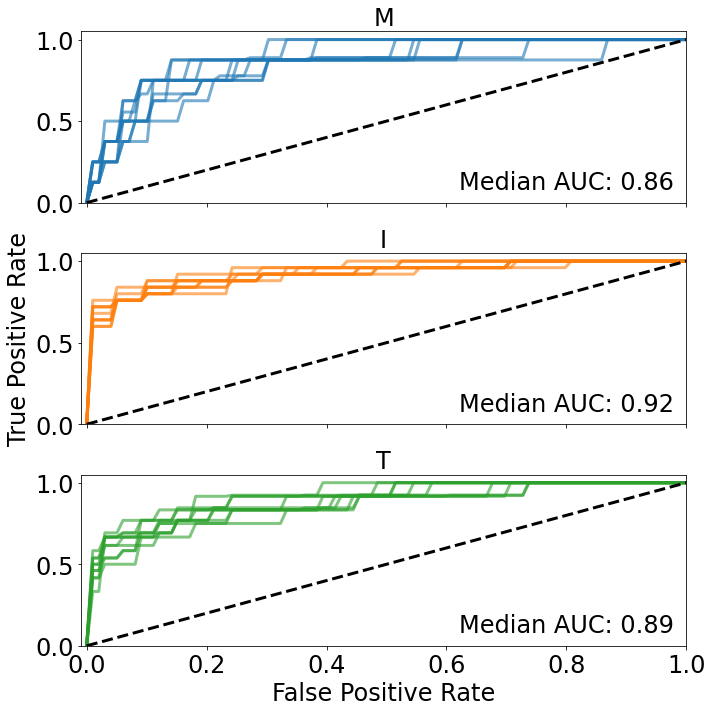

In [13]:
roc_curve = plot_eval(df, best_params["XGBClassifier"], eval_seeds=EVAL_RANDOM_SEEDS, num_folds=NUM_FOLDS)

In [14]:
if SAVE_PLOT: roc_curve.savefig(SAVE_PLOT_PATH + "roc_auc_full.pdf", dpi=300, bbox_inches="tight")

You may also choose to plot the mean curve for each seed by specifying the `stat_func` argument as `np.mean`. The same is true for the precision-recall curve.

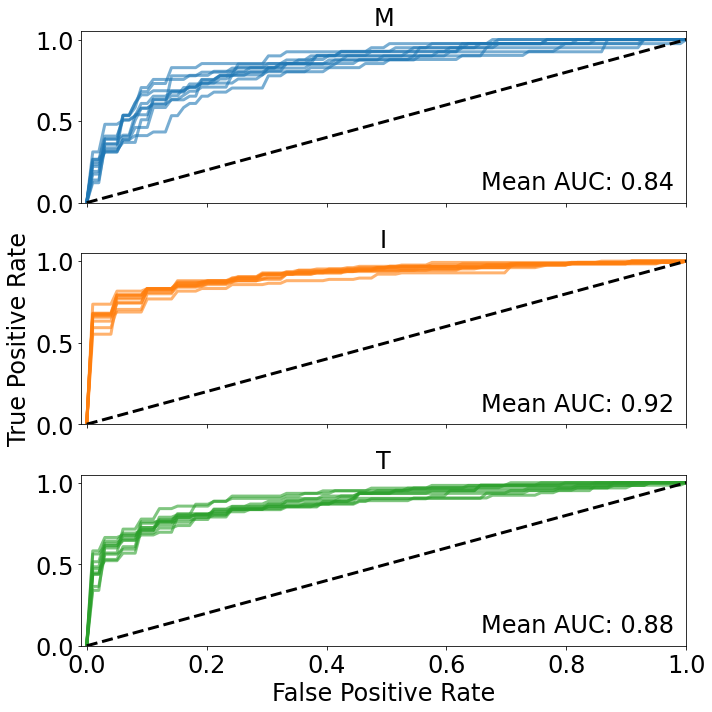

In [15]:
roc_curve_mean = plot_eval(df, best_params["XGBClassifier"], eval_seeds=EVAL_RANDOM_SEEDS, num_folds=NUM_FOLDS, stat_func=np.mean)

## Precision-recall curve

For each precision-recall curve, there is a naive precision line. This line just represents the precision value from a naive classifier that always predict the positive class. As a result, the naive precision is equal to the proportion of the positive class for each binary classification. For instance, around 18% of the observations are metals.

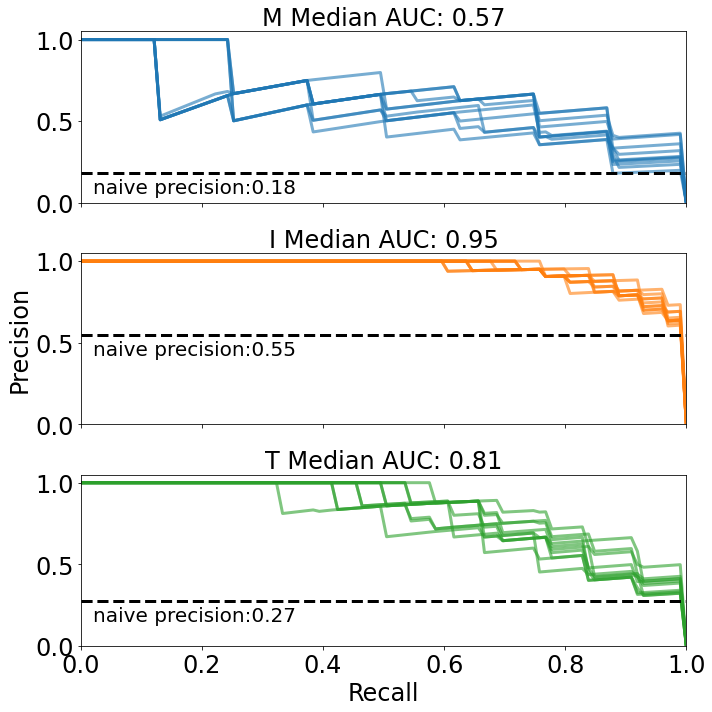

In [16]:
pr_curve = plot_eval(df, best_params["XGBClassifier"], eval_seeds=EVAL_RANDOM_SEEDS, num_folds=NUM_FOLDS, eval_method="pr")

In [17]:
if SAVE_PLOT: pr_curve.savefig(SAVE_PLOT_PATH + "pr_curve_full.pdf", dpi=300, bbox_inches="tight")

# Train on the entire dataset and save the models

In [18]:
for choice in ["Metal", "Insulator", "MIT"]:
    X, y = load_data(df, choice)
    xgb_tuned_model = xgb.XGBClassifier(**best_params["XGBClassifier"][choice])
    xgb_tuned_model.fit(X, y)
    xgb_tuned_model.save_model("../model/saved_models/new_models/{}.model".format(choice.lower()))

# Feature importance and selection using SHAP values

First we need to load in classifiers trained with the full feature set.

In [19]:
# load the metal vs. non_metal classifier
metal_model = xgb.XGBClassifier()
metal_model.load_model("../model/saved_models/new_models/metal.model")

# load the insulator vs. non_insulator classifier
insulator_model = xgb.XGBClassifier()
insulator_model.load_model("../model/saved_models/new_models/insulator.model")

# load the mit vs. non_mit classifier
mit_model = xgb.XGBClassifier()
mit_model.load_model("../model/saved_models/new_models/mit.model")

## Metal vs. non-metal classifier

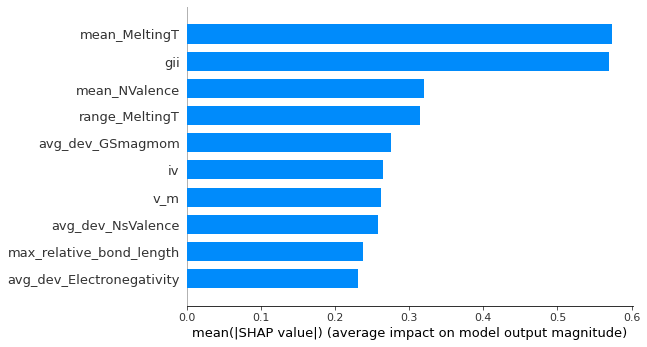

In [20]:
metal_important_features = get_important_features(df, "Metal", metal_model)

In [21]:
metal_important_features

,feature,shap_values
0,mean_MeltingT,0.573281
1,gii,0.569344
2,mean_NValence,0.320051
3,range_MeltingT,0.315244
4,avg_dev_GSmagmom,0.275741
5,iv,0.265054
6,v_m,0.262554
7,avg_dev_NsValence,0.258020
8,max_relative_bond_length,0.238007
9,avg_dev_Electronegativity,0.231642


## Insulator vs. non-insulator classifier

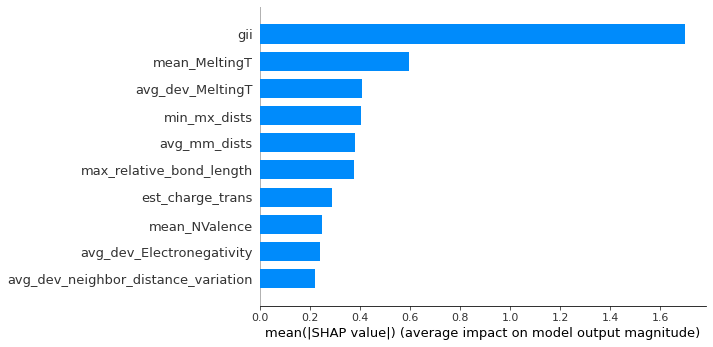

In [22]:
insulator_important_features = get_important_features(df, "Insulator", insulator_model)

In [23]:
insulator_important_features

,feature,shap_values
0,gii,1.697996
1,mean_MeltingT,0.595308
2,avg_dev_MeltingT,0.408559
3,min_mx_dists,0.403854
4,avg_mm_dists,0.381298
5,max_relative_bond_length,0.375335
6,est_charge_trans,0.290216
7,mean_NValence,0.247545
8,avg_dev_Electronegativity,0.241463
9,avg_dev_neighbor_distance_variation,0.219866


## MIT vs. non-MIT classifier

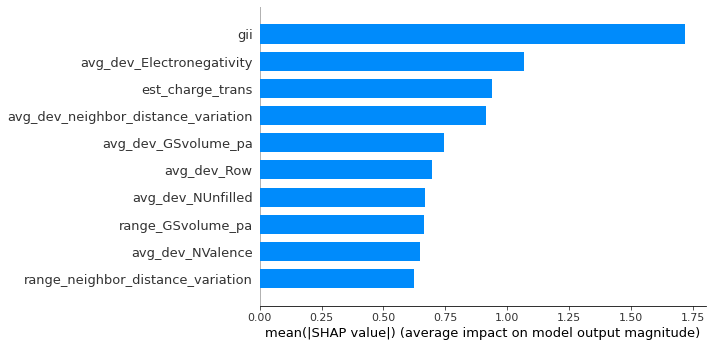

In [24]:
mit_important_features = get_important_features(df, "MIT", mit_model)

In [25]:
mit_important_features

,feature,shap_values
0,gii,1.718059
1,avg_dev_Electronegativity,1.069522
2,est_charge_trans,0.938671
3,avg_dev_neighbor_distance_variation,0.915330
4,avg_dev_GSvolume_pa,0.744060
5,avg_dev_Row,0.696316
6,avg_dev_NUnfilled,0.666662
7,range_GSvolume_pa,0.665808
8,avg_dev_NValence,0.648702
9,range_neighbor_distance_variation,0.623007


In [26]:
mit_important_features.feature.to_list()

['gii',
 'avg_dev_Electronegativity',
 'est_charge_trans',
 'avg_dev_neighbor_distance_variation',
 'avg_dev_GSvolume_pa',
 'avg_dev_Row',
 'avg_dev_NUnfilled',
 'range_GSvolume_pa',
 'avg_dev_NValence',
 'range_neighbor_distance_variation']

## Get a frequency count for the important features

First define a function to look up the feature in the 3 important feature dataframe

In [27]:
def get_source_model(row):
    """Get the source binary model from which the feature is deemed important"""
    # get the feature name
    feature = row["feature_name"]
    # define a list of source dataframes
    lst_sources = [metal_important_features, insulator_important_features, mit_important_features]
    # check if the feature is in any of the dataframes in the list
    indicators = [1 if feature in df_source.feature.to_list() else 0 for df_source in lst_sources]
    return indicators

Then we can see where and how many times each important feature shows up in the 3 binary classifiers

In [28]:
feature_frequency = pd.concat([metal_important_features.feature, 
                               insulator_important_features.feature, 
                               mit_important_features.feature],
                              ignore_index=True).value_counts()
feature_frequency_df = pd.DataFrame({"feature_name": feature_frequency.index, "frequency": feature_frequency.values})
feature_frequency_df[["in_metal", "in_insulator", "in_mit"]] = feature_frequency_df.apply(get_source_model, result_type="expand", axis=1)
feature_frequency_df

,feature_name,frequency,in_metal,in_insulator,in_mit
0,avg_dev_Electronegativity,3,1,1,1
1,gii,3,1,1,1
2,max_relative_bond_length,2,1,1,0
3,mean_NValence,2,1,1,0
4,mean_MeltingT,2,1,1,0
5,avg_dev_neighbor_distance_variation,2,0,1,1
6,est_charge_trans,2,0,1,1
7,avg_mm_dists,1,0,1,0
8,min_mx_dists,1,0,1,0
9,avg_dev_MeltingT,1,0,1,0


## Select features based on feature importance and domain knowledge

In [29]:
selected_features = ["Compound", "Label", "struct_file_path", # these 3 are included for human reference
                     "gii", "est_hubbard_u",  "est_charge_trans", "ewald_energy_per_atom",
                     "maximum_MendeleevNumber", "range_MendeleevNumber", "avg_dev_CovalentRadius",
                     "avg_mm_dists", "avg_mx_dists", "avg_xx_dists"]
selected_features

['Compound',
 'Label',
 'struct_file_path',
 'gii',
 'est_hubbard_u',
 'est_charge_trans',
 'ewald_energy_per_atom',
 'maximum_MendeleevNumber',
 'range_MendeleevNumber',
 'avg_dev_CovalentRadius',
 'avg_mm_dists',
 'avg_mx_dists',
 'avg_xx_dists']

## Get the reduced feature set and redo the tuning and training process

In [30]:
df_reduced = df[selected_features]
df_reduced.to_excel("../data/processed/IMT_Classification_Dataset_Reduced_Feature_Set_v9.xlsx", index=False)
df_reduced

,Compound,Label,struct_file_path,gii,est_hubbard_u,est_charge_trans,ewald_energy_per_atom,maximum_MendeleevNumber,range_MendeleevNumber,avg_dev_CovalentRadius,avg_mm_dists,avg_mx_dists,avg_xx_dists
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_CollCode_2915...,0.321007,10.523409,11.946426,-35.287498,87,78,56.880000,4.040770,2.020385,2.857256
1,BaNiS2,0,../data/Structures/Metals/BaNiS2_CollCode_2469...,0.195702,12.893512,21.595766,-18.401393,88,79,38.875000,3.491120,2.331183,3.654519
2,BaOsO3,0,../data/Structures/Metals/BaOsO3_SD_0375565.cif,0.817185,8.412244,3.591515,-32.606822,87,78,54.480000,2.577001,2.105553,2.978994
3,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_CollCode_73...,0.277386,10.043255,11.876142,-39.922005,87,31,37.487603,3.639266,1.938742,3.077187
4,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7_CollCode_15...,0.117212,10.277936,8.827434,-33.810870,87,80,47.638889,3.868727,1.992857,2.933553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,V6O13,2,../data/Structures/MIT_materials/HighT/V6O13_H...,0.198242,58.592940,-12.467020,-51.589654,87,41,37.595568,3.387826,1.938791,2.767633
224,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,0.296188,13.875184,11.940681,-44.765762,87,41,39.470699,3.269840,1.952518,2.819850
225,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,0.128538,14.484546,9.779242,-47.781257,87,41,38.666667,3.522330,1.927294,2.675472
226,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3_6...,0.231001,15.898371,10.393278,-34.202393,87,75,43.680000,3.755161,1.963601,2.827539


# Training pipeline on the reduced feature set

## Hyperparameter tuning

In [31]:
best_params = {choice: tune_hyperparam(df_reduced, choice, TRAIN_RANDOM_SEED)
               for choice in ["Metal", "Insulator", "MIT"]}
# pause the execution for 1 second to ensure proper printout format
time.sleep(1)
print("\nBest parameters:")
pprint.pprint(best_params)


Tuning for Metal vs. non-Metal binary classifier
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 11760 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Tuning for Insulator vs. non-Insulator binary classifier
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 8432 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 12032 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 16432 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Tuning for MIT vs. non-MIT binary classifier
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 9600 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 14000 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  1.7min finished



Best parameters:
{'Insulator': {'base_score': 0.5,
               'learning_rate': 1.0,
               'max_depth': 5,
               'n_estimators': 100,
               'random_state': 31415926,
               'scale_pos_weight': 0.824,
               'subsample': 0.7},
 'MIT': {'base_score': 0.3,
         'learning_rate': 1.0,
         'max_depth': 3,
         'n_estimators': 200,
         'random_state': 31415926,
         'scale_pos_weight': 2.6774193548387095,
         'subsample': 0.5},
 'Metal': {'base_score': 0.5,
           'learning_rate': 0.01,
           'max_depth': 4,
           'n_estimators': 150,
           'random_state': 31415926,
           'scale_pos_weight': 4.560975609756097,
           'subsample': 0.5}}


## Cross validation evaluation

### Median with interquartile range

In [32]:
xgb_reduced_eval = []
for choice in ["Metal", "Insulator", "MIT"]:
    xgb_reduced_eval.append(evaluate_model(EVAL_RANDOM_SEEDS, SCORING_METRICS, choice, df_input=df_reduced, params=best_params, 
                                           method="robust", num_folds=NUM_FOLDS))
xgb_reduced_performance = pd.concat(xgb_reduced_eval, ignore_index=True)


----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the Metal vs. non-Metal binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.84 w/ IQR: 0.03
Median recall_weighted: 0.84 w/ IQR: 0.02
Median roc_auc: 0.85 w/ IQR: 0.03
Median f1_weighted: 0.84 w/ IQR: 0.03

----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the Insulator vs. non-Insulator binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.81 w/ IQR: 0.03
Median recall_weighted: 0.80 w/ IQR: 0.02
Median roc_auc: 0.88 w/ IQR: 0.01
Median f1_weighted: 0.80 w/ IQR: 0.02

----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the MIT vs. non-MIT binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.86 w/ IQR: 0.03
Median recall_weighted: 0.87 w/ IQR:

Save the XGBClassifier's performance on the reduce feature set

In [33]:
xgb_reduced_performance.insert(1, "feature_set", "Reduced")
xgb_reduced_performance.to_excel("../data/processed/xgboost_reduced_model_metrics.xlsx", index=False)
xgb_reduced_performance

,model_type,feature_set,positive_class,metric_name,metric_value,metric_dispersion,raw_metric
0,XGBClassifier,Reduced,Metal,precision_weighted,0.841431,0.028773,"[0.8616021659499921, 0.8557252905078991, 0.840..."
1,XGBClassifier,Reduced,Metal,recall_weighted,0.835266,0.024638,"[0.8695652173913043, 0.8478260869565217, 0.822..."
2,XGBClassifier,Reduced,Metal,roc_auc,0.851351,0.026871,"[0.847972972972973, 0.8256578947368421, 0.8986..."
3,XGBClassifier,Reduced,Metal,f1_weighted,0.838054,0.025928,"[0.863129290617849, 0.8512872975277067, 0.8296..."
4,XGBClassifier,Reduced,Insulator,precision_weighted,0.807877,0.025974,"[0.8074534161490682, 0.8025210084033613, 0.786..."
5,XGBClassifier,Reduced,Insulator,recall_weighted,0.802174,0.017391,"[0.8043478260869565, 0.8, 0.782608695652174, 0..."
6,XGBClassifier,Reduced,Insulator,roc_auc,0.877000,0.011500,"[0.882, 0.878, 0.8742857142857142, 0.876, 0.86..."
7,XGBClassifier,Reduced,Insulator,f1_weighted,0.801477,0.017787,"[0.8023600681517005, 0.7975522692503824, 0.783..."
8,XGBClassifier,Reduced,MIT,precision_weighted,0.864743,0.026263,"[0.8666290231507624, 0.8204404291360813, 0.866..."
9,XGBClassifier,Reduced,MIT,recall_weighted,0.866667,0.024275,"[0.8695652173913043, 0.8260869565217391, 0.866..."


### Mean with standard deviation

In [34]:
for choice in ["Metal", "Insulator", "MIT"]:
    evaluate_model(EVAL_RANDOM_SEEDS, SCORING_METRICS, choice, df_input=df_reduced, params=best_params, 
                   method="standard", num_folds=NUM_FOLDS)


----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the Metal vs. non-Metal binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.84 w/ std: 0.02
Mean recall_weighted: 0.84 w/ std: 0.01
Mean roc_auc: 0.83 w/ std: 0.02
Mean f1_weighted: 0.83 w/ std: 0.02

----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the Insulator vs. non-Insulator binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.80 w/ std: 0.01
Mean recall_weighted: 0.80 w/ std: 0.01
Mean roc_auc: 0.87 w/ std: 0.01
Mean f1_weighted: 0.79 w/ std: 0.01

----------------------------------------------------------------------
Model type: XGBClassifier
Evaluating the MIT vs. non-MIT binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.86 w/ std: 0.02
Mean recall_weighted: 0.85 w/ std: 0.02
Mean roc_auc: 

## Plot ROC & precision-recall curves

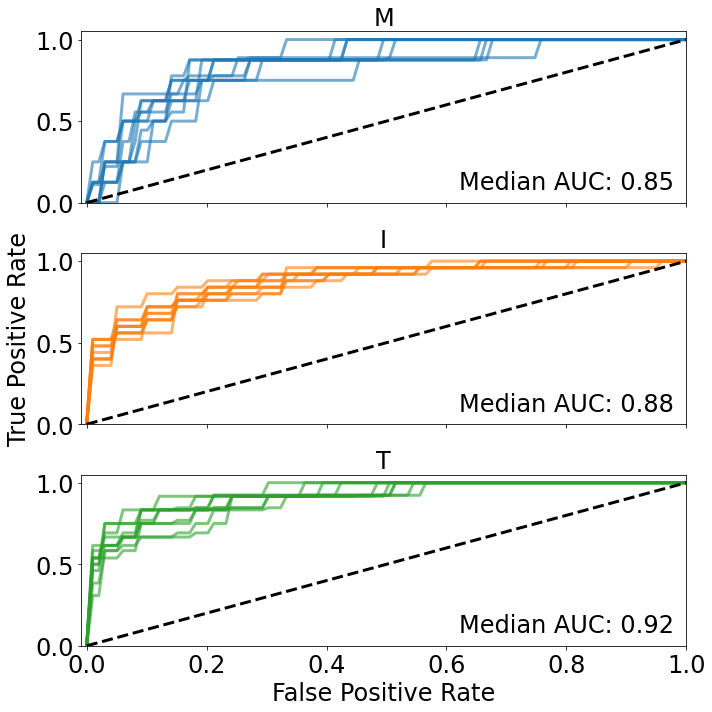

In [35]:
roc_curve_reduced = plot_eval(df_reduced, best_params, eval_seeds=EVAL_RANDOM_SEEDS, num_folds=NUM_FOLDS)

In [36]:
if SAVE_PLOT: roc_curve_reduced.savefig(SAVE_PLOT_PATH + "roc_auc_reduced.pdf", dpi=300, bbox_inches="tight")

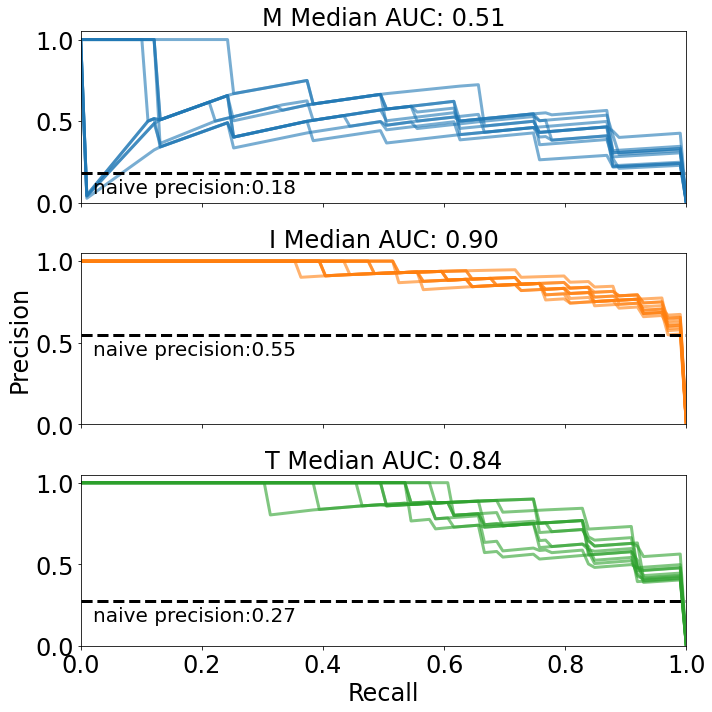

In [37]:
pr_curve_reduced = plot_eval(df_reduced, best_params, eval_seeds=EVAL_RANDOM_SEEDS, num_folds=NUM_FOLDS, eval_method="pr")

In [38]:
if SAVE_PLOT: pr_curve_reduced.savefig(SAVE_PLOT_PATH + "pr_curve_reduced.pdf", dpi=300, bbox_inches="tight")

## Save models trained on the reduced feature set

In [39]:
for choice in ["Metal", "Insulator", "MIT"]:
    X, y = load_data(df_reduced, choice)
    xgb_tuned_model = xgb.XGBClassifier(**best_params[choice])
    xgb_tuned_model.fit(X, y)
    xgb_tuned_model.save_model("../model/saved_models/new_models/{}_reduced.model".format(choice.lower()))